In [3]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['font.size'] = 20
rcParams['axes.unicode_minus'] = False

In [5]:
import os
from tqdm import tqdm
import pandas as pd

sp_data_dict = dict()

for file_name in tqdm(os.listdir("data/주가데이터")):
    sp_data = pd.read_csv("data/주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

100%|██████████| 2170/2170 [00:18<00:00, 118.11it/s]


In [7]:
for stock_name in tqdm(sp_data_dict.keys()):
    # 이동평균선 계산
    sp_data = sp_data_dict[stock_name]
    sp_data['MA_5'] = sp_data['Close'].rolling(5).mean()
    sp_data['MA_20'] = sp_data['Close'].rolling(20).mean()
    sp_data['MA_60'] = sp_data['Close'].rolling(60).mean()
    sp_data['MA_120'] = sp_data['Close'].rolling(120).mean()
    sp_data.dropna(inplace = True)

100%|██████████| 2170/2170 [00:06<00:00, 332.05it/s]


In [8]:
import itertools
import numpy as np

# 골든크로스, 데드크로스 변수 추가
for stock_name in tqdm(sp_data_dict.keys()):
    sp_data = sp_data_dict[stock_name]

    # product : 변수들을 조합해줌 = 카티션 프로덕트
    # 단기 이평선들과 장기 이평선들을 비교
    for cross, st, lt in itertools.product(['G', 'D'], [5, 20], [60, 120]):
        output_col = "{}_{}_{}".format(cross, st, lt)
        st_col = "MA_" + str(st)
        lt_col = "MA_" + str(lt)
        st_data = sp_data[st_col].values
        lt_data = sp_data[lt_col].values

        if cross == "G":
            output = (st_data[1:] >= lt_data[1:]) & (st_data[:-1] < lt_data[:-1])
        elif cross == "D":
            output = (st_data[1:] < lt_data[1:]) & (st_data[:-1] >= lt_data[:-1])

        output = np.insert(output, 0, False)
        sp_data[output_col] = output

100%|██████████| 2170/2170 [00:03<00:00, 570.52it/s]


Text(0.5, 0, '날짜')

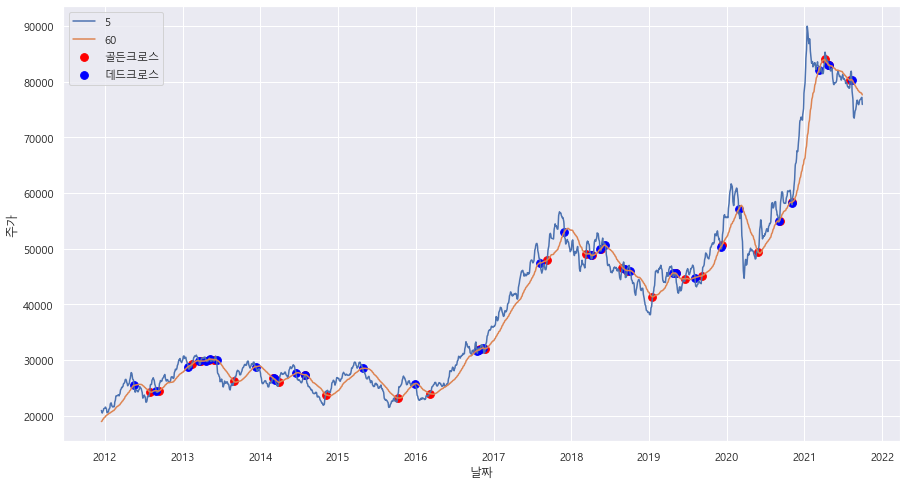

In [9]:
plt.figure(figsize = (15, 8))

samsung = sp_data_dict['삼성전자']
plt.plot(samsung['Date'], samsung['MA_5'], label = "5")
plt.plot(samsung['Date'], samsung['MA_60'], label = "60")

golden_cross_data = samsung.loc[samsung['G_5_60']]
dead_cross_data = samsung.loc[samsung['D_5_60']]

plt.scatter(golden_cross_data['Date'], golden_cross_data['MA_60'], label = "골든크로스", color = "red", s = 60)
plt.scatter(dead_cross_data['Date'], dead_cross_data['MA_60'], label = "데드크로스", color = "blue", s = 60)
plt.legend()
plt.ylabel("주가")
plt.xlabel("날짜")

# 이벤트 발생 주기가 불규칙적이고 발생 횟수가 많아서 검증이 필요함

In [12]:
# 골든 크로스에서 전액 매수, 데트 크로스에서 전액 매도하는 전략 테스트

def calc_ror_using_gd_cross(sp_data_dict, stock_name, st, lt):
    money = 10 ** 8
    sp_data = sp_data_dict[stock_name]
    gc_idx_list = sp_data.loc[sp_data['G_{}_{}'.format(st, lt)]].index
    dc_idx_list = sp_data.loc[sp_data['D_{}_{}'.format(st, lt)]].index

    for buy_idx in gc_idx_list:
        if sum(dc_idx_list > buy_idx) == 0:  # 제일 마지막에 발생한 크로스가 골든 크로스
            sell_idx = sp_data.index.max()  # 이렇게 구매된 주식은 마지막 날 매도함
        else:
            sell_idx = dc_idx_list[dc_idx_list > buy_idx].min()  # 현재 buy_idx인 매수된 날짜에서 가장 가까운 다음 데드크로스를 매도시점으로 설정

        buy_price = sp_data.loc[buy_idx, 'Close']
        sell_price = sp_data.loc[sell_idx, 'Close']
        num_stocks = money / buy_price
        money = num_stocks * sell_price

    ror = (money - 10 ** 8) / 10 ** 8 * 100
    return round(ror, 3)

print(calc_ror_using_gd_cross(sp_data_dict, "삼성전자", 5, 60))

98.862


In [13]:
# 수익률 비교를 위한 바이앤홀드 전략

def calc_ror_using_buy_and_hold(sp_data_dict, stock_name):
    sp_data = sp_data_dict[stock_name]
    buy_price = sp_data["Close"].iloc[0]
    sell_price = sp_data["Close"].iloc[-1]

    ror = (sell_price - buy_price) / buy_price * 100
    return ror

print(calc_ror_using_buy_and_hold(sp_data_dict, "삼성전자"))

# 단순히 사고 가지고 있는 전략이 훨씬 높은 수익률을 보임

254.54545454545453


In [14]:
# 다른 모든 종목에 적용

result = []
for stock_name in tqdm(sp_data_dict.keys()):
    record = [stock_name]
    for st, lt in itertools.product([5, 20], [60, 120]):
        profit = calc_ror_using_gd_cross(sp_data_dict, stock_name, st, lt)
        record.append(profit)

    ror = calc_ror_using_buy_and_hold(sp_data_dict, stock_name)
    record.append(ror)
    result.append(record)

result = pd.DataFrame(result, columns = ["종목명", "5-60", "5-120", "20-60", "20-120", "바이앤홀드"])
print(result.describe().round(2))

# 다른 전략보다 바이앤홀드 전략이 압도적으로 우수함

100%|██████████| 2170/2170 [00:31<00:00, 68.21it/s]


          5-60    5-120    20-60   20-120    바이앤홀드
count  2170.00  2170.00  2170.00  2170.00  2170.00
mean     66.36    47.06    56.17    49.13   142.42
std     236.84   189.54   224.80   193.11   337.55
min     -96.52   -96.65   -97.16   -96.62   -99.80
25%     -34.09   -38.42   -34.52   -37.97   -17.93
50%       5.51    -1.18     0.99     0.00    48.27
75%      82.49    63.89    71.26    65.90   176.82
max    5638.30  3404.18  4757.39  3332.33  6327.76


In [15]:
print(result.set_index('종목명').idxmax(axis = 1).value_counts(normalize = True))

# 종목별로 각 전략을 적용했을때의 1위 분포
# 역시 바이앤홀드 전략이 압도적으로 높음

바이앤홀드     0.498618
5-60      0.156221
20-60     0.126267
20-120    0.115207
5-120     0.103687
dtype: float64
